# ImageWoof Regularization Experiments
- Dataset: [ImageNette](https://github.com/fastai/imagenette)
- Official [Tutorial](https://docs.fast.ai/tutorial.vision.html) by FastAI
- [MOOC](https://course.fast.ai/videos/)
- Documentation about image m https://docs.fast.ai/vision.models.xresnet.html
- Inofficial Tutorials/docs
  - [ImageWoof](https://kdorichev.github.io/deeplearning//Image_Classification_Imagewoof) tutorial with wrong labels
  - [Interesting Notebook](https://kshitij09.github.io/fast_impl/visualize.grad_cam/) using woof dataset




# Setup
__WARNING:__ The Setup currently includes an interactive function to google drive. If you run the notebook, you have to provide the api key in the environment section, otherwise it will stop at that point without executing anything else.

## Environment

In [ ]:
#setup fastai notebook
!pip install -Uqq fastai #fastbook 
# import fastbook
# fastbook.setup_book()

In [ ]:
#@title imports
# from fastbook import *
from fastai.vision.all import *

from fastprogress import fastprogress
from torchvision.models import *
# Only necessary if we want to save the results to drive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Load Dataset

Different Datasets available in URLs [[source]](https://docs.fast.ai/data.external):
- __IMAGENETTE__: A smaller version of the imagenet dataset pronounced just like 'Imagenet', except with a corny inauthentic French accent.
- __IMAGENETTE_160__: The 160px version of the Imagenette dataset.
- __IMAGENETTE_320__: The 320px version of the Imagenette dataset.
- __IMAGEWOOF__: Imagewoof is a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds.
- __IMAGEWOOF_160__: 160px version of the ImageWoof dataset.
- __IMAGEWOOF_320__: 320px version of the ImageWoof dataset.

In [ ]:
# TODO: Why are we not using the 160 - Version of Imagewoof if we are going to crop it to 128 anyway?

# true for imagewoof, else imagenette
woof = True
if woof:
  path = untar_data(URLs.IMAGEWOOF_160)
else:
  path = untar_data(URLs.IMAGENETTE)

files = get_image_files(path/"train")
print("Training images: ", len(get_image_files(path/"train")),'(' ,round(len(get_image_files(path/"train"))*100/len(get_image_files(path)),2), '%)')
print("Validation images: ", len(get_image_files(path/"val")),'(' ,round(len(get_image_files(path/"val"))*100/len(get_image_files(path)),2), '%)')


Training images:  9025 ( 69.67 %)
Validation images:  3929 ( 30.33 %)


In [ ]:
#setup data

#dls = ImageDataLoaders.from_folder(path, valid='val', item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))
#dls.show_batch()

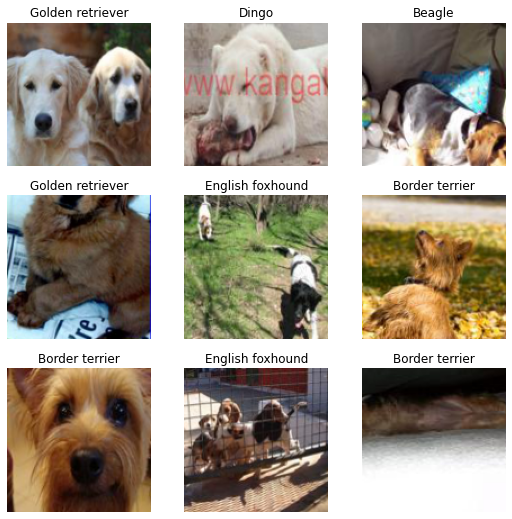

In [ ]:
#get all the images
fnames = get_image_files(path)

#create dict to show better readable labels
if woof:
  lbl_dict = dict(
    n02086240= 'Shih-Tzu',
    n02087394= 'Rhodesian ridgeback',
    n02088364= 'Beagle',
    n02089973= 'English foxhound',
    n02093754= 'Australian terrier',
    n02096294= 'Border terrier',
    n02099601= 'Golden retriever',
    n02105641= 'Old English sheepdog',
    n02111889= 'Samoyed',
    n02115641= 'Dingo'
  )
else:
  lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
  )
#function to return human readable filenames
# def label_func(fname):
#   return lbl_dict[parent_label(fname)]

#define a datablock
dblock = DataBlock(
      #set input to image and the goal to ctaegories
      blocks = (ImageBlock, CategoryBlock),
      #get names inside data block
      get_items = get_image_files,
      #label the items uin a readbale manner
      # get_y=label_func,
      get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
      #split between test and trainining by folder two ages above
      splitter = GrandparentSplitter(valid_name='val'),
      #randomize the input & batch transform
      item_tfms = RandomResizedCrop(128, min_scale=0.35), 
      batch_tfms = Normalize.from_stats(*imagenet_stats)
      )

  #convert to dataloader
dls = dblock.dataloaders(path)
dls.show_batch()

## Confirm Images

In [ ]:
# fnames2 = get_image_files(path/"train/n02093754/")
# dblock = DataBlock(
#       #set input to image and the goal to ctaegories
#       blocks = (ImageBlock, CategoryBlock),
#       #get names inside data block
#       get_items = get_image_files,
#       #label the items uin a readbale manner
#       get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
#       #split between test and trainining by folder two ages above
#       splitter = GrandparentSplitter(valid_name='val'),
#       #randomize the input & batch transform
#       item_tfms = RandomResizedCrop(128, min_scale=0.35), 
#       batch_tfms = Normalize.from_stats(*imagenet_stats)
#       )

#   #convert to dataloader
# dls = dblock.dataloaders(path/"train/n02087394/")
# # print(dls.vocab) # print all labels
# dls.show_batch()

## Set Default Values

In [ ]:
LEARNING_RATE = 8e-3
EPOCHS = 20
restultStoragePath = 'drive/MyDrive/DL_results'
model = xresnext50(n_out=10, sa=True, pool=MaxPool)
optimizer = partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6)
callbacks = []

# (Optimized) Base Model

In [ ]:
# !ls drive/MyDrive/DL_results

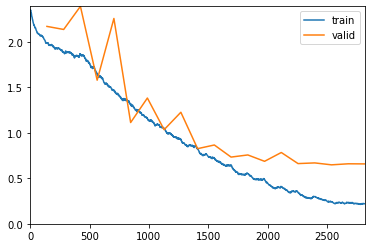

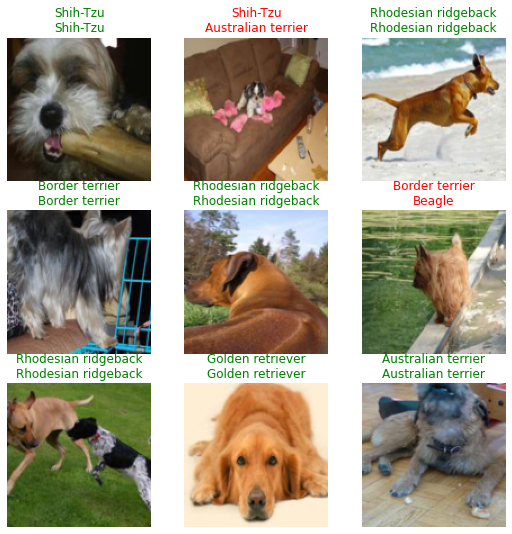

In [ ]:
callbackExtension = [CSVLogger(fname='base_model.csv'),ShowGraphCallback()]
learn = Learner(dls, model, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

# Experiments

## Pooling

### AvgPool

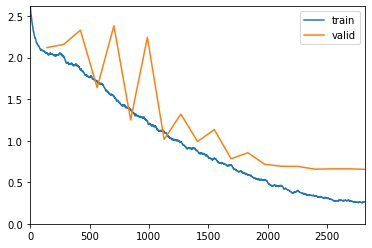

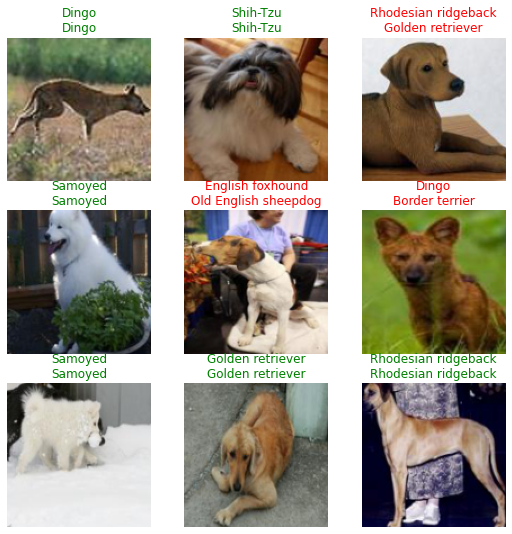

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_avg_pooling.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=AvgPool)
learn = Learner(dls, modifiedModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

### AdaptiveAvgPool

In [ ]:
# Doesnt work yet.

### MaxBlurPool
Probably need to implement this myself.
[Some](https://github.com/ayasyrev/imagenette_experiments/) [more](https://github.com/ducha-aiki/Ranger-Mish-ImageWoof-5/blob/master/mxresnet.py#L121) [Resources](https://forums.fast.ai/t/imagenette-imagewoof-leaderboards/45822/19) 

Lets Try ResNext just for fun

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


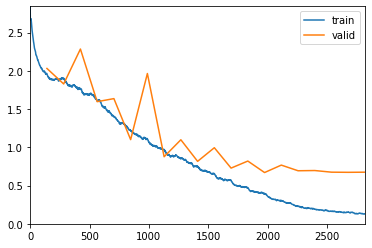

In [ ]:
!pip install -Uqq kornia
# import kornia
# layer_new = kornia.contrib.MaxBlurPool2d(3, True)
# learn = Learner(dls,                      
#                     #xse_resnext50
#                     XResNet(SEResNeXtBlock, 4, g1, n_out=10, sa=True, pool=MaxPool), 
#                     opt_func=partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6), 
                    
#                     metrics=accuracy)
# learn.fit_one_cycle(20, 8e-3)
# learn.show_results()

# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

# Train
cModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
cModel = convert_MP_to_blurMP(cModel, nn.MaxPool2d)
callbackExtension = [CSVLogger(fname='base_model_with_max_blur_pool.csv'),ShowGraphCallback()]
learn = Learner(dls, cModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# loss_func=LabelSmoothingCrossEntropy() # this is used in the original
lr = 1e-2
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
# learn.fit_flat_cos(EPOCHS, lr, wd=1e-2, cbs=callbacks+callbackExtension) # this is used in the original

### MaxBlurPool with LabelSmoothingCrossEntropy

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


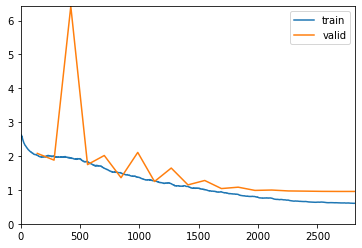

In [ ]:
# Train
cModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
cModel = convert_MP_to_blurMP(cModel, nn.MaxPool2d)
callbackExtension = [CSVLogger(fname='base_model_with_max_blur_pool_and_LabelSmoothingCrossEntropy.csv'),ShowGraphCallback()]
learn = Learner(dls, cModel, opt_func=optimizer, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(), cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# loss_func=LabelSmoothingCrossEntropy() # this is used in the original
lr = 1e-2
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
# learn.fit_flat_cos(EPOCHS, lr, wd=1e-2, cbs=callbacks+callbackExtension) # this is used in the original

In [ ]:
# has_pool_type(resnet34)
# learn.model # get the model
# print(resnet34)

# m = create_body(resnet34)


# new_md = nn.Sequential(*list(children(md))[:-5], custom_head) # assuming pooling is at layer -5, remove it and then put a custom head ontop
# learn_new = ConvLearner.from_model_data(new_md, data) # create a new learner with the new model


<function resnet34 at 0x7f08300a6048>


In [ ]:
# import kornia
# layer_new = kornia.contrib.MaxBlurPool2d(3, True)
# # from https://github.com/ducha-aiki/imagewoofv2-fastv2-maxpoolblur/blob/master/fastai2-imagenette-train-maxblurpool.ipynb



ModuleNotFoundError: ignored

## Loss functions
- L2
- L1
- [More](https://docs.fast.ai/losses.html) ?


Can be changed in the learner as param or after the learner has been defined with loss_func=torch.nn.CrossEntropyLoss

There is also a [FastAI Article](https://docs.fast.ai/tutorial.imagenette#Changing-the-loss-function) for custom loss functions

### L2 Regularization (Weight decay)
The default weight decay in fastai is 1e-2. (See Base Model for comparison)

__READ__
- [Paper](https://arxiv.org/abs/1706.05350) 




#### No Weight Decay

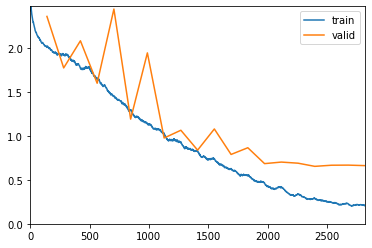

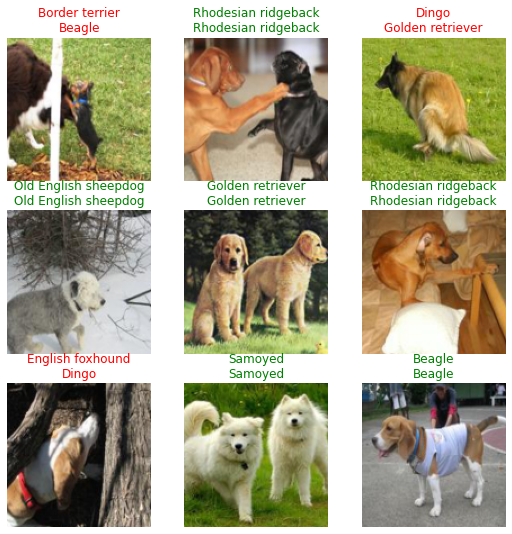

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_no_weight_decay.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath, wd=0)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

#### Weight Decay: 0.05

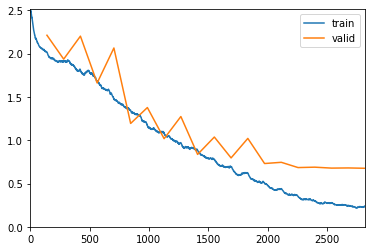

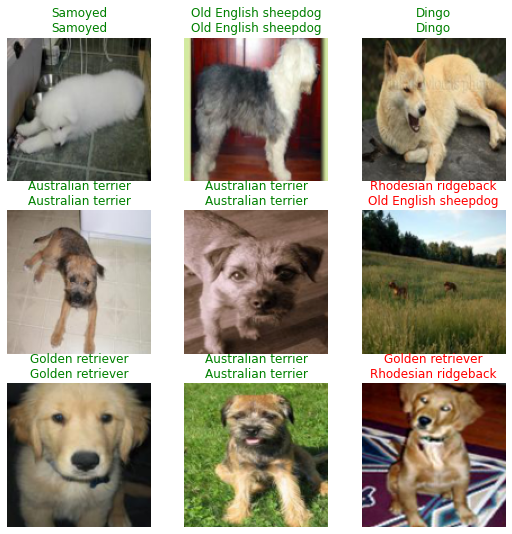

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_5e-2_weight_decay.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath, wd=5e-2)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

#### Weight Decay: 0.1

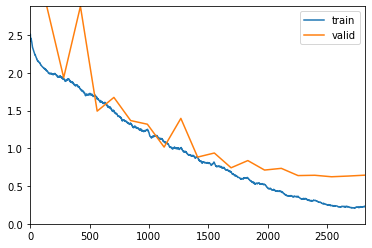

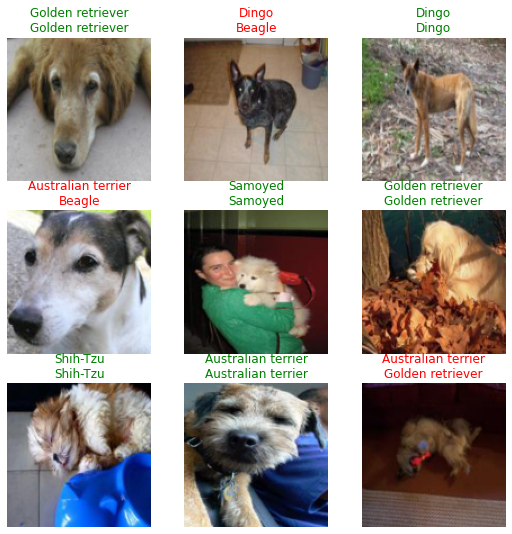

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_1e-1_weight_decay.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath, wd=1e-1)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

#### Weight Decay: 0.3

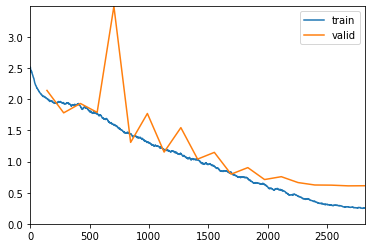

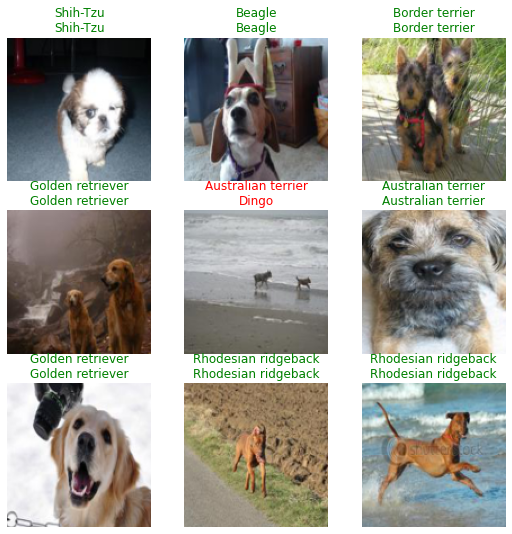

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_3e-1_weight_decay.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath, wd=3e-1)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

#### Weight Decay: 0.4


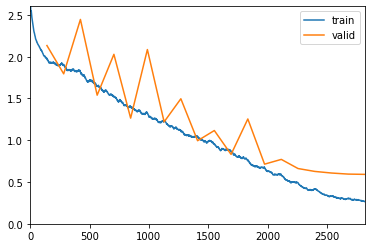

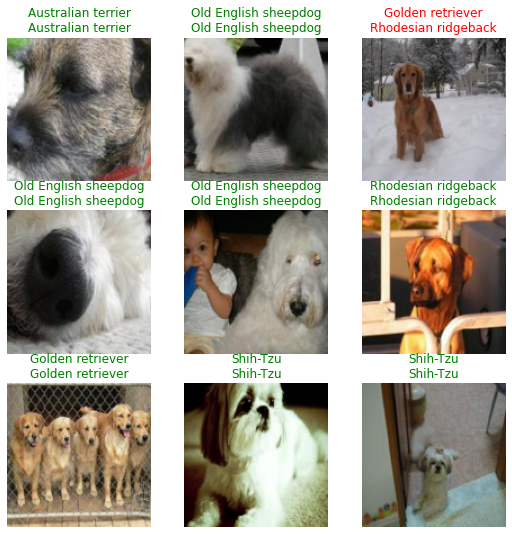

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_4e-1_weight_decay.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel, opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath, wd=4e-1)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

### L1 Regularization

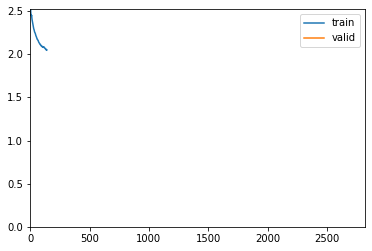

KeyboardInterrupt: ignored

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_l1_loss.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
# nn.L1Loss is also a possibility
#######
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)
######


learn = Learner(dls, modifiedModel,loss_func=LabelSmoothingCE(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

# geht auch, nachdem der Learner bereits erstellt wurde: 
#  loss_func=torch.nn.CrossEntropyLoss

### MSELoss


In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_MSELossFlat.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel,loss_func=MSELossFlat(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

IndexError: ignored

### BCEWithLogitsLossFlat

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_BCEWithLogitsLossFlat.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel,loss_func=BCEWithLogitsLossFlat(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

### LabelSmoothingCrossEntropyFlat

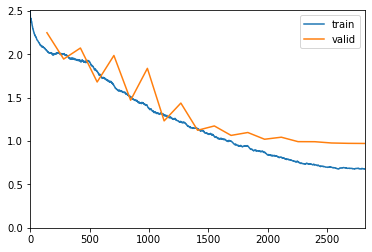

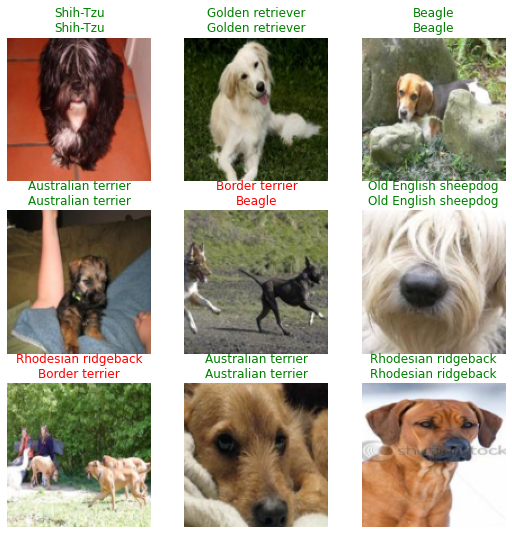

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_LabelSmoothingCrossEntropyFlat.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel,loss_func=LabelSmoothingCrossEntropyFlat(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

### LabelSmoothingCrossEntropy

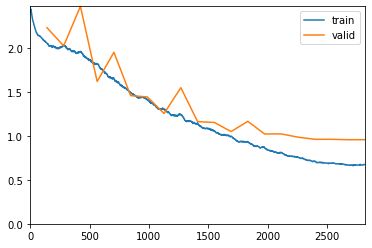

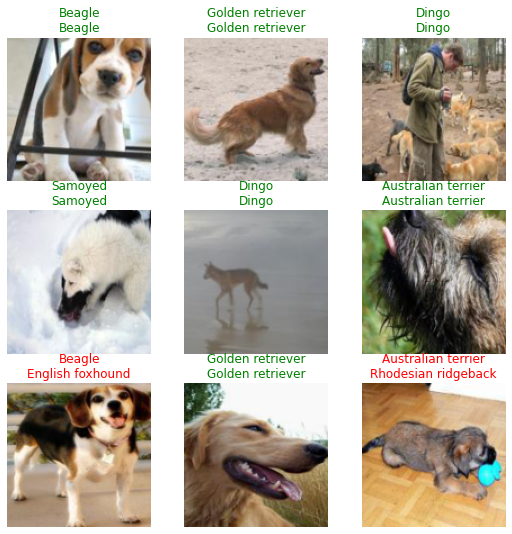

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_custom_labelsmoothing_cross_entropy.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
#######
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)
######


learn = Learner(dls, modifiedModel,loss_func=LabelSmoothingCE(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

# geht auch, nachdem der Learner bereits erstellt wurde: 
#  loss_func=torch.nn.CrossEntropyLoss

### BCELossFlat

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_BCELossFlat.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel,loss_func=BCELossFlat(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

IndexError: ignored

### CrossEntropyLossFlat

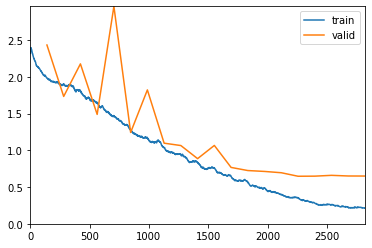

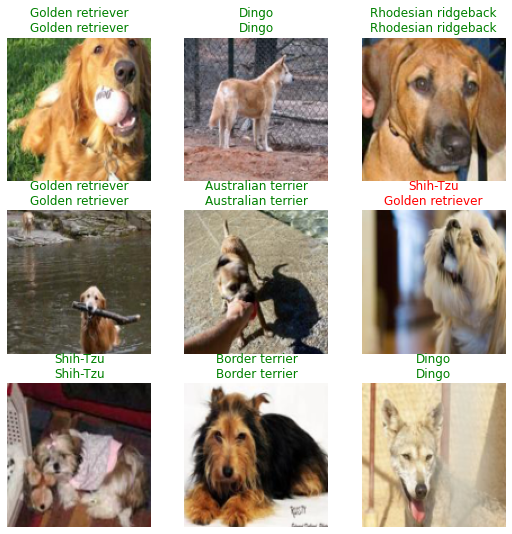

In [ ]:
callbackExtension = [CSVLogger(fname='base_model_with_crossentropylossflat.csv'),ShowGraphCallback()]
modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
learn = Learner(dls, modifiedModel,loss_func=CrossEntropyLossFlat(), opt_func=optimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                ,path = restultStoragePath)
# Train
learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
learn.show_results()

## Momentum

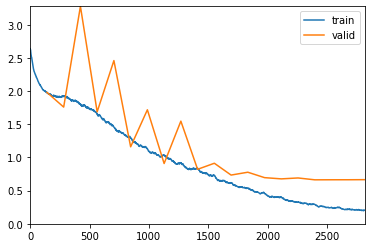

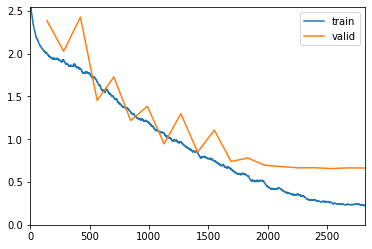

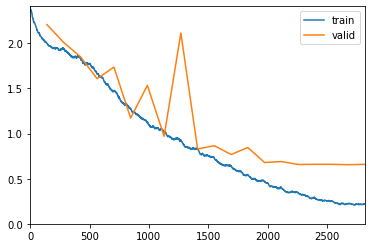

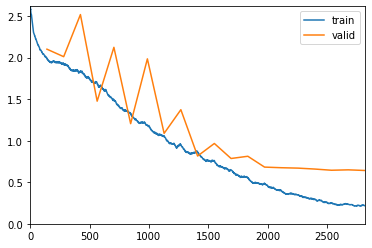

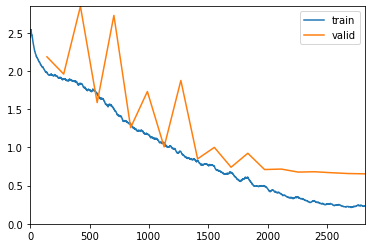

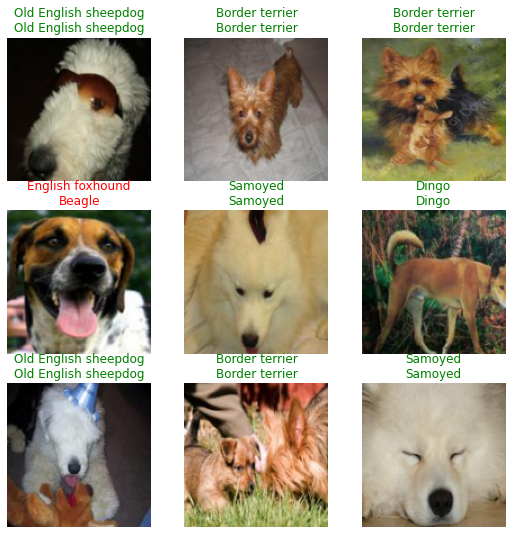

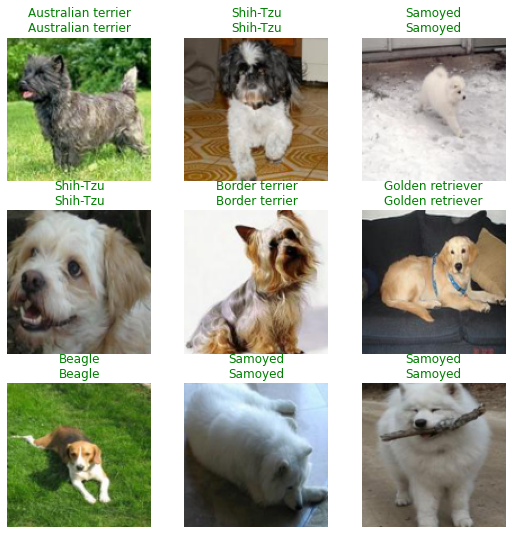

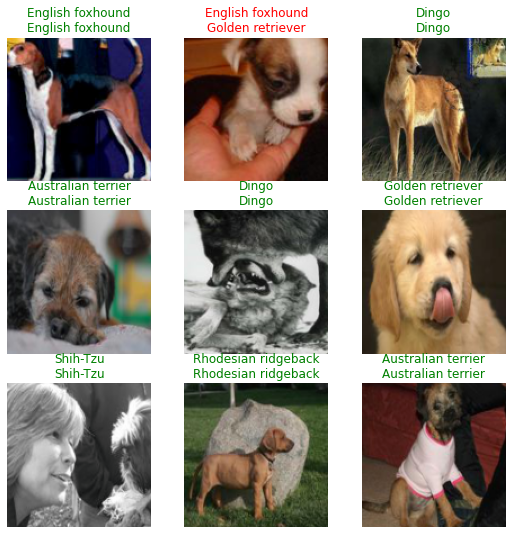

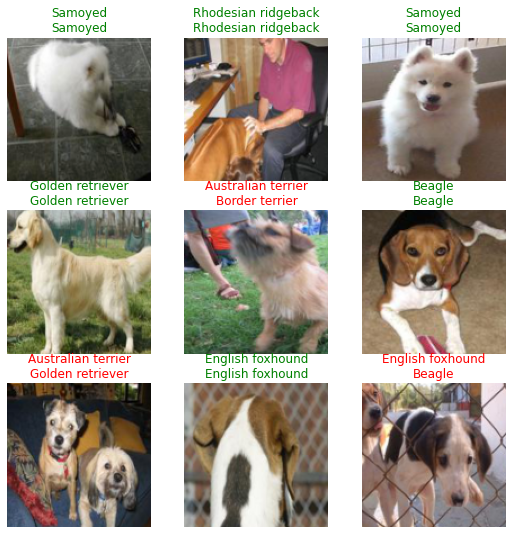

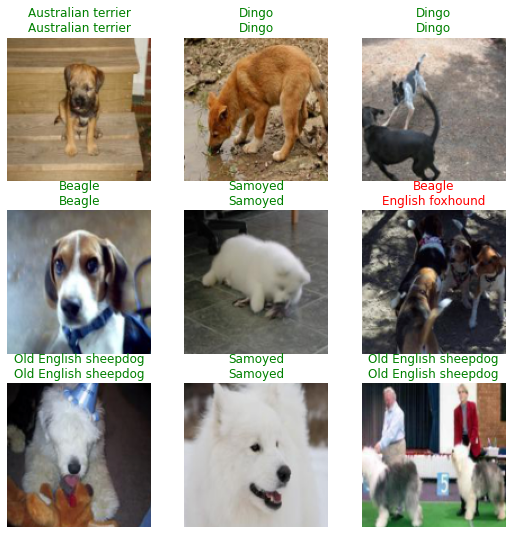

In [ ]:
for tVal in range(80,95,3):
  m = tVal / 100
  modifiedOptimizer = partial(ranger, mom=m, sqr_mom=.99, eps=1e-6)
  callbackExtension = [CSVLogger(fname='base_model_with_'+str(m)+'_momentum.csv'),ShowGraphCallback()]
  modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
  learn = Learner(dls, modifiedModel, opt_func=modifiedOptimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                  ,path = restultStoragePath)
  # Train
  learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
  learn.show_results()

## sqr_momentum

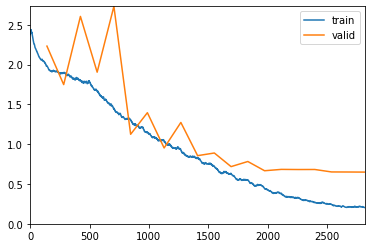

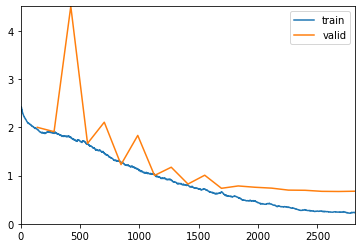

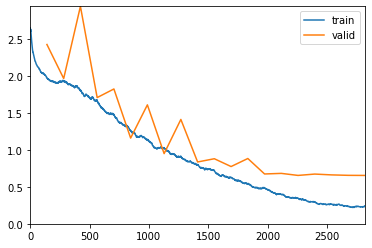

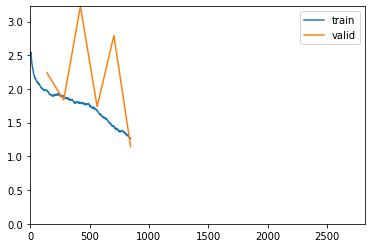

Buffered data was truncated after reaching the output size limit.

In [ ]:
for tVal in range(99,78,-5):
  m = tVal / 100
  modifiedOptimizer = partial(ranger, mom=.95, sqr_mom=m, eps=1e-6)
  callbackExtension = [CSVLogger(fname='base_model_with_'+str(m)+'_sqr_momentum.csv'),ShowGraphCallback()]
  modifiedModel = xresnext50(n_out=10, sa=True, pool=MaxPool)
  learn = Learner(dls, modifiedModel, opt_func=modifiedOptimizer, metrics=accuracy, cbs=callbacks+callbackExtension
                  ,path = restultStoragePath)
  # Train
  learn.fit_one_cycle(EPOCHS, LEARNING_RATE)
  learn.show_results()